# Machine Learning Tutorial 

Tutorial Created by: Haley Schuhl

Date: Jul 24, 2023

Tutorial Updated by: ZhakeYa D. Hawkins

Date:  July 16, 2025

The Naive Bayes multiclass approach is an extension of the Naive Bayes approach. It can be trained to output binary images given an input color image. Unlike the Naive Bayes method, the Naive Bayes multiclass approach can be trained to classify two or more classes, defined by the user. Additionally, the Naive Bayes multiclass method is trained using colors sparsely sampled from a images rather than the need to label all pixels in a given image.

To train the classifier, we need to build a table of red, green, and blue color values for pixels sampled evenly from each class. The idea here is to collect a relevant sample of pixel color data for each class. The size of the sample needed to build robust probability density functions for each class will depend on a number of factors, including the variability in class colors and imaging quality/reproducibility. To collect pixel color data we currently use the Pixel Inspection Tool in [ImageJ](https://imagej.net/ij/). Each column in the tab-delimited table is a feature class (in this example, plant, pustule, chlorosis, or background)
and each cell is a comma-separated red, green, and blue triplet for a pixel.





Once a satisfactory sample of pixels is collected, save the table as a tab-delimited text file. Use `plantcv-train` to use the pixel samples to output probability density functions (PDFs)
for each class.

plantcv-train naive_bayes_multiclass --file pixel_samples.txt --outfile naive_bayes_pdfs.txt --plots

The output file from `plantcv-train` will contain one row for each color channel (hue, saturation, and value) for
each class. The first and second column are the class and channel label, respectively. The
remaining 256 columns contain the p-value from the PDFs for each intensity value observable in an 8-bit image (0-255).

Once we have the `plantcv-train` output file, we can classify pixels in a color image in PlantCV. In the example image for this tutorial we have already collected pixels and created the probability density functions for each class. 

In [ ]:
# Install PlantCV and Google Colab required dependencies
%pip install "altair>=5" ipympl plantcv

# Give access and mount your Google Drive (need a Google Account)
# Change path to directory you wish output files to be saved to.
from google.colab import drive
drive.mount('/content/gdrive')

# Enable widget feature with matplotlib
from google.colab import output
output.enable_custom_widget_manager()

#View working directory, may need to change path
%pwd

# Change your working directory to the mounted drive 
%cd gdrive/MyDrive/ 
# Print the contents of your drive to confirm it worked 
!ls 
# Clone the workshop's repository to your Google Drive 
!git clone https://github.com/danforthcenter/plantcv-tutorial-machine-learning.git


Binder detected.


In [2]:
# Import libraries
%matplotlib widget
import numpy as np
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

In [ ]:
# Input/Output options
args = WorkflowInputs(
    #images=["img/color_image.jpg"],    
    images=["RGB_image.jpg"],   
    names="image1",
    result="ml_tutorial_results.json",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

# Set debug as a global parameter 
pcv.params.debug = args.debug


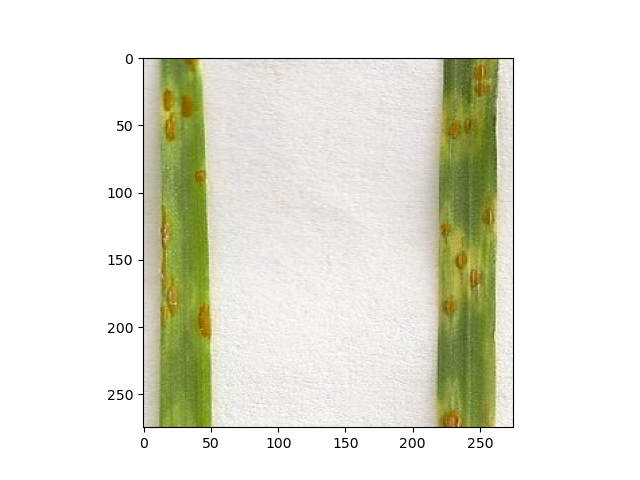

In [9]:
# Read image in

img, path, filename = pcv.readimage(filename=args.image1)


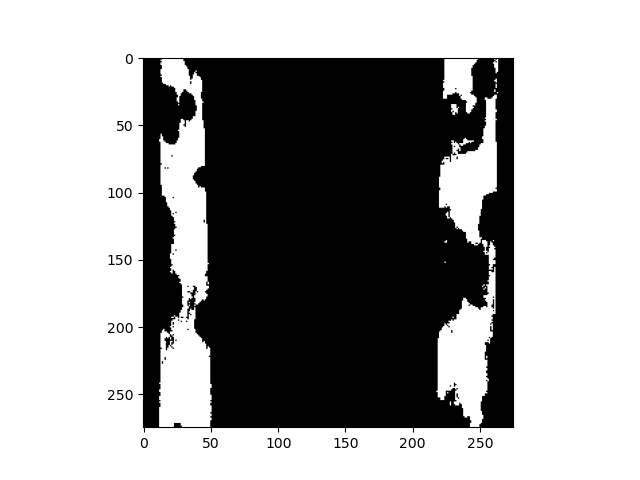

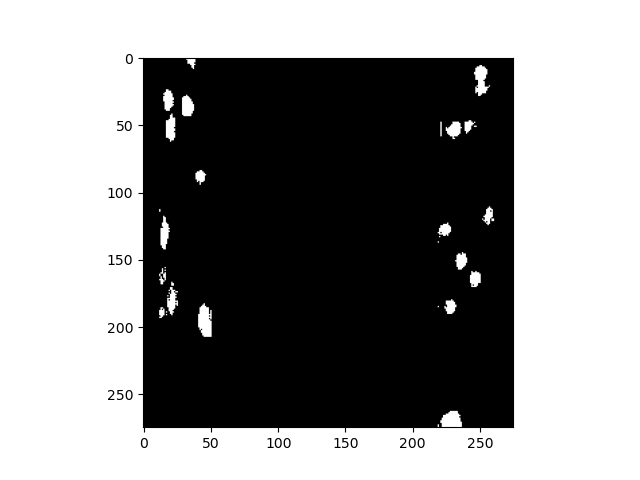

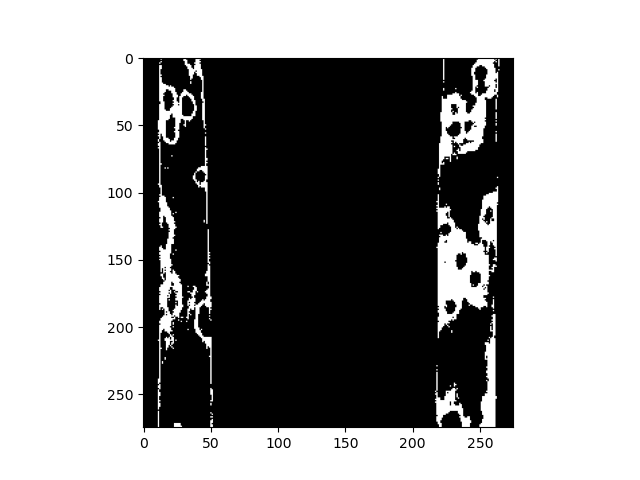

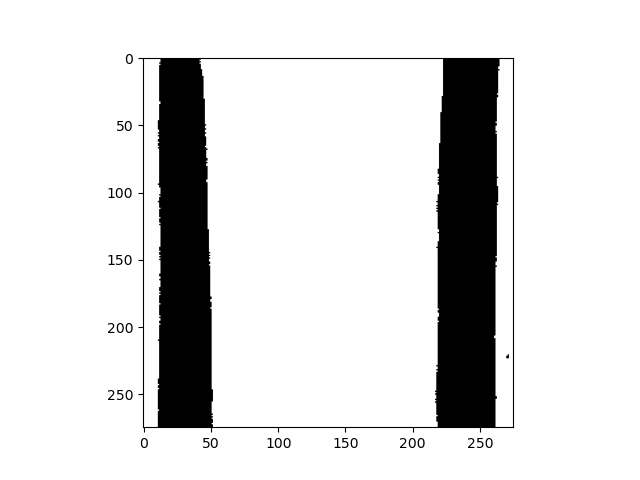

In [ ]:
# Use the output file from `plantcv-train.py` to run the multiclass 
# Naive Bayes classification on the image. The function below will 
# print out 4 masks (plant, pustule, chlorosis, background)

# Inputs: 
#   rgb_img - RGB image data 
#   pdf_file - Output file containing PDFs from `plantcv-train.py`
mask = pcv.naive_bayes_classifier(rgb_img=img, 
                                  pdf_file="./img/machine_learning.txt")


In [ ]:
# We can apply each mask over the original image to more accurately 
# see what got masked


plant_img = pcv.apply_mask(mask=(mask['plant']), img=img, mask_color='black')
pustule_img = pcv.apply_mask(mask=(mask['pustule']), img=img, mask_color='black')
chlorosis_img = pcv.apply_mask(mask=(mask['chlorosis']), img=img, mask_color='black')
background_img = pcv.apply_mask(mask=(mask['background']), img=img, mask_color='black')


NameError: name 'mask' is not defined

In [6]:
# Write image and mask with the same name to the path 
# specified (creates two folders within the path if they do not exist).

plant_maskpath, plant_analysis_images = pcv.output_mask(img=img, mask=mask['plant'], 
                                                        filename='plant.png', mask_only=True)
pust_maskpath, pust_analysis_images = pcv.output_mask(img=img, mask=mask['pustule'], 
                                                      filename='pustule.png', mask_only=True)
chlor_maskpath, chlor_analysis_images = pcv.output_mask(img=img, mask=mask['chlorosis'], 
                                                        filename='chlorosis.png', mask_only=True)
bkgrd_maskpath, bkgrd_analysis_images = pcv.output_mask(img=img, mask=mask['background'], 
                                                        filename='background.png', mask_only=True)


NameError: name 'img' is not defined

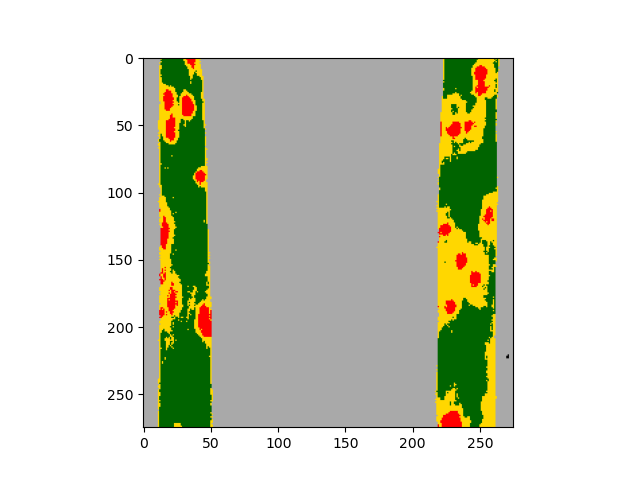

In [ ]:
# To visually see all of these masks together we can plot them with plant set to green,
# chlorosis set to gold, and pustule set to red.

classified_img = pcv.visualize.colorize_masks(masks=[mask['plant'], mask['pustule'],
                                                     mask['chlorosis'], mask['background']],
                                              colors=['dark green', 'red', 'gold', 'gray'])


In [ ]:
# Calculate percentage of the plant found to be diseased 

sick_plant = np.count_nonzero(mask['pustule']) + np.count_nonzero(mask['chlorosis'])
healthy_plant = np.count_nonzero(mask['plant'])
percent_diseased = sick_plant / (sick_plant + healthy_plant)


In [ ]:
# Create a new measurement (gets saved to the outputs class) 

pcv.outputs.add_observation(sample='default', variable='percent_diseased', 
                            trait='percent of plant detected to be diseased',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_diseased, label='percent')


In [ ]:
# Data stored to the outputs class can be accessed using the variable name
pcv.outputs.observations['default']['percent_diseased']['value']

0.40697462114296146

In [ ]:
# save_results
pcv.outputs.save_results(filename=args.result)

To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) CLick on the file named “ml_tutorial_results.txt”

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 
